In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import MinMaxScaler

### 获取数据

In [4]:
new_data = pd.read_csv('../data/new_data.csv')

In [5]:
new_data = new_data.drop(['Unnamed: 0', 'light', 'wind_speed', 'wind_direction_angle', 'weather_status', 'precipitation'], axis=1)

In [6]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        75552 non-null  float64
 1   temperature  75552 non-null  float64
 2   humidity     75552 non-null  float64
 3   pressure     75552 non-null  float64
 4   visibility   75552 non-null  float64
 5   holiday      75552 non-null  float64
 6   minute       75552 non-null  float64
 7   week         75552 non-null  float64
 8   year         75552 non-null  float64
dtypes: float64(9)
memory usage: 5.2 MB


In [7]:
new_data = new_data.astype(np.float32)

In [8]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        75552 non-null  float32
 1   temperature  75552 non-null  float32
 2   humidity     75552 non-null  float32
 3   pressure     75552 non-null  float32
 4   visibility   75552 non-null  float32
 5   holiday      75552 non-null  float32
 6   minute       75552 non-null  float32
 7   week         75552 non-null  float32
 8   year         75552 non-null  float32
dtypes: float32(9)
memory usage: 2.6 MB


2021年、2022年、2023年年初电力负荷均出现了明显的先下降后上升过程，但原因不明，需要和电力公司沟通，了解原因。因此在模型训练和测试时选择将这段时间的数据忽略。

删去2021-1-21到2021-2-6，2022-2-9到2022-2-24，2023-1-26到2023-2-13的数据

In [9]:
drop_index = [i for i in range(1920, 3552)] + [i for i in range(38784, 40320)] + [i for i in range(72480, 74304)]

In [10]:
new_data = new_data.drop(drop_index, axis=0)

In [11]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70560 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        70560 non-null  float32
 1   temperature  70560 non-null  float32
 2   humidity     70560 non-null  float32
 3   pressure     70560 non-null  float32
 4   visibility   70560 non-null  float32
 5   holiday      70560 non-null  float32
 6   minute       70560 non-null  float32
 7   week         70560 non-null  float32
 8   year         70560 non-null  float32
dtypes: float32(9)
memory usage: 3.0 MB


划分训练集和测试集。2021年、2022年前11个月和2023年的数据作为训练集，2022年12月的数据作为测试集

In [12]:
train1 = new_data.loc[:1919]
train2 = new_data.loc[3552:38783]
train3 = new_data.loc[40320:67103]
train4 = new_data.loc[70080:72479]
train5 = new_data.loc[74304:]
train = pd.concat([new_data.loc[:67103], new_data.loc[70080:]], axis=0)
test = new_data.loc[67104:70079]

In [13]:
print(len(train))
print(len(test))

67584
2976


对训练集和测试集数据归一化

In [14]:
scaler = MinMaxScaler()
scaler = scaler.fit(train)  # fit，在这里本质是生成min(x)和max(x)
train_result1 = scaler.transform(train1)  # 结果为ndarray类型
train_result2 = scaler.transform(train2)
train_result3 = scaler.transform(train3)
train_result4 = scaler.transform(train4)
train_result5 = scaler.transform(train5)
test_result = scaler.transform(test)

In [15]:
scaler

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [16]:
train_result1.shape

(1920, 9)

In [17]:
train_result2.shape

(35232, 9)

In [18]:
train_result3.shape

(26784, 9)

In [19]:
train_result4.shape

(2400, 9)

In [20]:
train_result5.shape

(1248, 9)

In [21]:
test_result.shape

(2976, 9)

生成训练数据和测试数据

In [22]:
#  可以做个比较，有预测时刻的气象信息与没有预测时刻的气象信息。感觉有预测时刻的气象信息作为输入，模型预测准确性会受到天气预报准确性的影响。
#  生成的样本起始时刻依次相差15分钟
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw+1):
        train_seq = np.empty((96, 15), dtype=np.float32)
        for j in range(96):
            seq1 = input_data[i+j:i+tw-96:96, 0].reshape(-1)
            seq2 = input_data[i+tw-96+j, 1:].reshape(-1)
            seq = np.concatenate((seq1, seq2), axis=0)
            train_seq[j] = seq
        train_label = input_data[i+tw-96:i+tw, 0]
        inout_seq.append((torch.tensor(train_seq) ,torch.tensor(train_label)))
    return inout_seq

In [23]:
train_seq1 = create_inout_sequences(train_result1, 768)
train_seq2 = create_inout_sequences(train_result2, 768)
train_seq3 = create_inout_sequences(train_result3, 768)
train_seq4 = create_inout_sequences(train_result4, 768)
train_seq5 = create_inout_sequences(train_result5, 768)
train_seq = train_seq1 + train_seq2 + train_seq3 + train_seq4 + train_seq5
test_seq = create_inout_sequences(test_result, 768)

In [24]:
len(train_seq)

63749

In [25]:
len(test_seq)

2209

训练样本的数量为63749，每个训练样本包括特征和标签，其中特征有96个序列，每个序列为前7天同一个时刻的负荷和预测那天同一时刻的数据，时刻从0:00到23:45，标签为预测那天96个时刻的负荷值。

使用前7天和未来24小时的数据预测未来24小时的负荷

设置批量大小为128

In [26]:
trainloader = torch.utils.data.DataLoader(train_seq, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_seq, batch_size=len(test_seq))

In [27]:
len(trainloader)

499

In [28]:
len(testloader)

1

In [29]:
for i ,j in trainloader:
    print(i.shape)
    print(j.shape)
    break

torch.Size([128, 96, 15])
torch.Size([128, 96])


In [30]:
for i ,j in testloader:
    print(i.shape)
    print(j.shape)

torch.Size([2209, 96, 15])
torch.Size([2209, 96])


### 建立LSTM模型并训练

In [31]:
# 前7天的负荷数据和未来24小时的数据
class LstmNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.LSTM(15, 100, 1, batch_first=True)  # 这个lstm的输入为15个神经元，输出为100个神经元，每个训练样本一次训练这个lstm被重复执行了96次，
        self.layer2 = nn.Linear(100, 1)  # 或者形象地说这个lstm结构在时间上的长度为96。
        
    def forward(self, x):
        y1, _ = self.layer1(x)
        y2 = self.layer2(y1)
        return y2.reshape(-1, 96)

In [32]:
# 128*96*15 15*100 128*96*100 100*1 128*96*1 128*96  # 批量大小为128，batch_first=True

In [33]:
lstmnet = LstmNet()

In [34]:
lr = 0.0001
opt = optim.Adam(lstmnet.parameters(), lr=lr)

In [35]:
#    opt = optim.Adam(lstmnet.parameters(), lr=lr*0.9)

In [36]:
loss_function = nn.MSELoss()  # 方差/平均平方误差

In [37]:
loss_list = []

In [38]:
MAPE_list = [3.4174072209639403]

In [39]:
epochs = 1
for epoch in range(epochs):
    i = 0
    for xb, yb in trainloader:
        y = lstmnet(xb)
        loss = loss_function(y, yb)
        loss_list.append(loss.data)
        loss.backward()
        opt.step()
        opt.zero_grad()
        i += 1
        if i%10 == 0:
            print(loss.data)


tensor(0.1502)
tensor(0.1058)
tensor(0.0764)
tensor(0.0484)
tensor(0.0267)
tensor(0.0182)
tensor(0.0161)
tensor(0.0183)
tensor(0.0161)
tensor(0.0180)
tensor(0.0177)
tensor(0.0154)
tensor(0.0195)
tensor(0.0165)
tensor(0.0149)
tensor(0.0137)
tensor(0.0160)
tensor(0.0137)
tensor(0.0155)
tensor(0.0168)
tensor(0.0107)
tensor(0.0124)
tensor(0.0140)
tensor(0.0113)
tensor(0.0130)
tensor(0.0135)
tensor(0.0112)
tensor(0.0104)
tensor(0.0112)
tensor(0.0109)
tensor(0.0098)
tensor(0.0096)
tensor(0.0106)
tensor(0.0101)
tensor(0.0124)
tensor(0.0097)
tensor(0.0122)
tensor(0.0094)
tensor(0.0089)
tensor(0.0082)
tensor(0.0101)
tensor(0.0102)
tensor(0.0090)
tensor(0.0090)
tensor(0.0086)
tensor(0.0101)
tensor(0.0082)
tensor(0.0109)
tensor(0.0099)


自己设置的v_max v_min 

In [40]:
# 根据实际需求设置 v_max 和 v_min 的值
v_max = max(train['value'])
v_min = min(train['value'])
for x, y in testloader:
    true_label = y * (v_max - v_min) + v_min
    true_label = true_label.numpy()

In [41]:
epochs = 6
for epoch in range(epochs):
    i = 0
    for xb, yb in trainloader:
        y = lstmnet(xb)
        loss = loss_function(y, yb)
        loss_list.append(loss.data)
        loss.backward()
        opt.step()
        opt.zero_grad()
        i += 1
        if i%10 == 0:
            print(loss.data)
    print('本轮结束')
    for x, y in testloader:
        pred = lstmnet(x)
        true_pred = pred * (v_max - v_min) + v_min
        true_pred = true_pred.detach().numpy()
        APE_array = abs(true_pred - true_label) / true_label
        list1 = (sum(APE_array.T)) / 96
    rate = sum(list1) / len(list1) * 100
    print(str(rate) + '%')
    if rate < min(MAPE_list):
        torch.save(lstmnet.state_dict(), 'lstmnet_2_19')
    MAPE_list.append(rate)

tensor(0.0085)
tensor(0.0081)
tensor(0.0084)
tensor(0.0099)
tensor(0.0081)
tensor(0.0085)
tensor(0.0089)
tensor(0.0081)
tensor(0.0092)
tensor(0.0088)
tensor(0.0072)
tensor(0.0074)
tensor(0.0077)
tensor(0.0086)
tensor(0.0085)
tensor(0.0084)
tensor(0.0081)
tensor(0.0069)
tensor(0.0085)
tensor(0.0103)
tensor(0.0084)
tensor(0.0077)
tensor(0.0092)
tensor(0.0081)
tensor(0.0078)
tensor(0.0101)
tensor(0.0072)
tensor(0.0065)
tensor(0.0083)
tensor(0.0063)
tensor(0.0071)
tensor(0.0068)
tensor(0.0074)
tensor(0.0060)
tensor(0.0059)
tensor(0.0081)
tensor(0.0074)
tensor(0.0053)
tensor(0.0062)
tensor(0.0053)
tensor(0.0078)
tensor(0.0065)
tensor(0.0073)
tensor(0.0072)
tensor(0.0047)
tensor(0.0048)
tensor(0.0064)
tensor(0.0074)
tensor(0.0055)
本轮结束
5.77406747997711%
tensor(0.0062)
tensor(0.0096)
tensor(0.0055)
tensor(0.0049)
tensor(0.0065)
tensor(0.0054)
tensor(0.0052)
tensor(0.0066)
tensor(0.0059)
tensor(0.0079)
tensor(0.0055)
tensor(0.0045)
tensor(0.0043)
tensor(0.0078)
tensor(0.0059)
tensor(0.0063)
te

尽量使MAPE降到5%以下

### 预测

In [42]:
v_max = max(train['value'])
v_min = min(train['value'])

预测测试集里的某一样本

In [43]:
plt.rc('font',family='DengXian')

In [44]:
def picture(data, index):
    pred = lstmnet(data[index][0].reshape(1, 96, 15))
    true_label = data[index][1] * (v_max - v_min) + v_min
    true_label = true_label.numpy()
    true_pred = pred * (v_max - v_min) + v_min
    true_pred = true_pred.reshape(96)
    true_pred = true_pred.detach().numpy()
    before_day = data[index-96][1] * (v_max - v_min) + v_min
    before_day = before_day.numpy()
    
    
    
    plt.figure(figsize=(15, 5), dpi=80)

    X = np.linspace(0, 24, 96, endpoint=True)
    C,S,D = true_pred, true_label, before_day
    plt.plot(X, C, color='blue', label='预测')
    plt.plot(X, S, color='green', label='真实')
    plt.plot(X, D, color='yellow', label='前24小时')
    plt.legend(loc='upper left')
    plt.show()

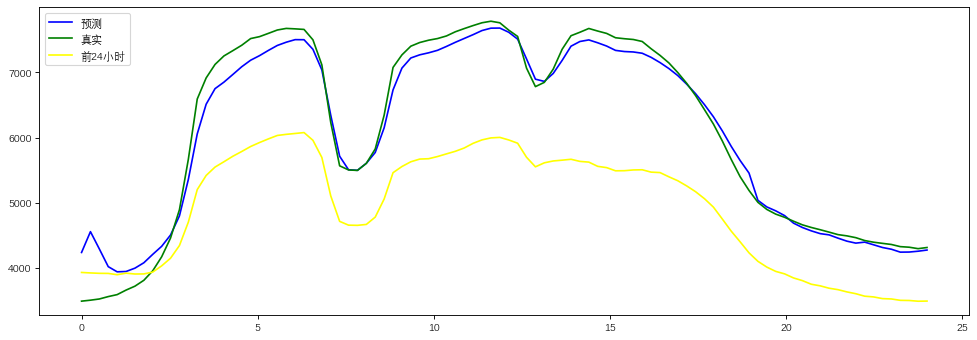

In [45]:
picture(test_seq, 500)

预测训练集里的某一样本

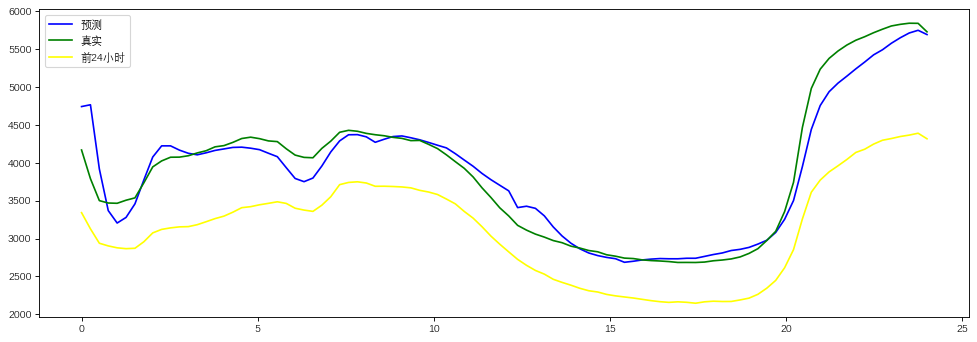

In [46]:
picture(train_seq, 6000)

加载训练好的模型参数

In [47]:
lstmnet.load_state_dict(torch.load('lstmnet_2_19'))

<All keys matched successfully>

采用所有样本APE的平均值(mean absolute percentage error)MAPE对模型的预测准确度进行评价

APE（绝对百分比误差）：|y预测 - y真实| ÷ y真实 × 100%

In [48]:
for x, y in testloader:
    pred = lstmnet(x)
    true_pred = pred * (v_max - v_min) + v_min
    true_pred = true_pred.detach().numpy()
    true_label = y * (v_max - v_min) + v_min
    true_label = true_label.numpy()
    APE_array = abs(true_pred - true_label) / true_label
    list1 = (sum(APE_array.T)) / 96

In [49]:
# 保存列表
np.save('lstm19_mape', list1)
# 加载列表
a = np.load('lstm19_mape.npy')

在测试数据上的MAPE

In [50]:
str(sum(list1) / len(list1) * 100) + '%'

'2.3963830874783385%'

In [51]:
min(MAPE_list)

3.4174072209639403

In [52]:
# 3.4174072209639403%  学习率0.01
# 5.112414281889492%
# 3.3253500115163472% 
# 3.509336767145658%
# 3.3265849022677902%
# 2.5648136045817487%
# 3.7180047896266957%
# 2.643353258284469%   学习率0.001
# 3.5444131975630095%
# 2.912302671616746%
# 2.710766884894184%
# 2.6025873555554324%
# 2.489940402945002%
# 2.537331301482852%
# 2.588455757862332%
# 2.3963830265355237%   2_19
# 2.760494189992911%
# 2.5639582831149474%
# 2.526144454767527%
# 2.4566337271037417%  学习率0.0001
# 2.5035853808195125%
# 2.4987265565244994%
# 2.480592684999054%
# 2.4888717922293098%
# 2.446621709097229%
# 2.4527354563694765%
# 2.4554636838288126%
# 2.47179303580078%
# 2.464954966266887%
# 2.5391807137356524%
# 2.4853531681228853%

In [53]:
# 每次训练后若模型在测试集上的损失减小，则保存这次训练的模型，若连续6次训练在测试集上的损失没有小于之前的模型，则将之前的模型作为最终的模型。
torch.save(lstmnet.state_dict(), 'lstmnet_2_19')

测试数据的APE分布的箱线图

<Axes: >

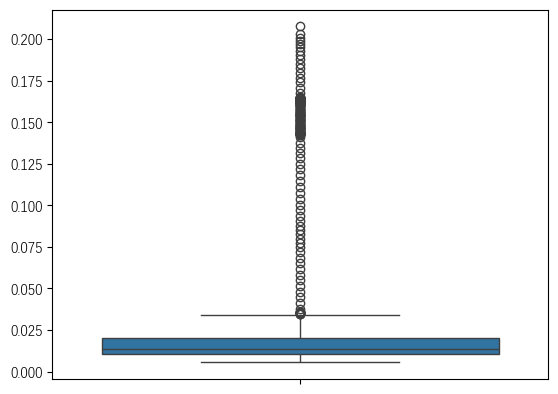

In [54]:
sns.boxplot(data=list1)

(0.0, 0.05)

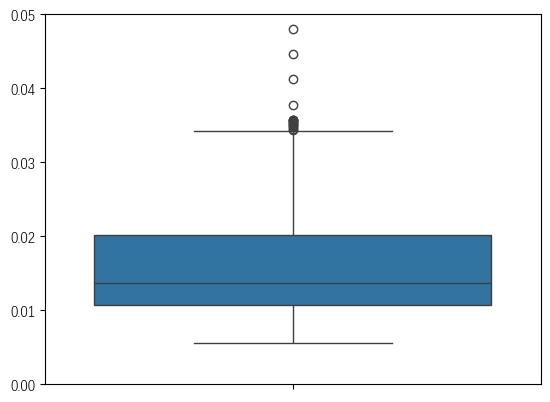

In [55]:
sns.boxplot(data=list1)
plt.ylim(0, 0.05)

In [56]:
min(list1)

0.00552235

In [57]:
max(list1)

0.20759602

测试数据的APE分布的折线图

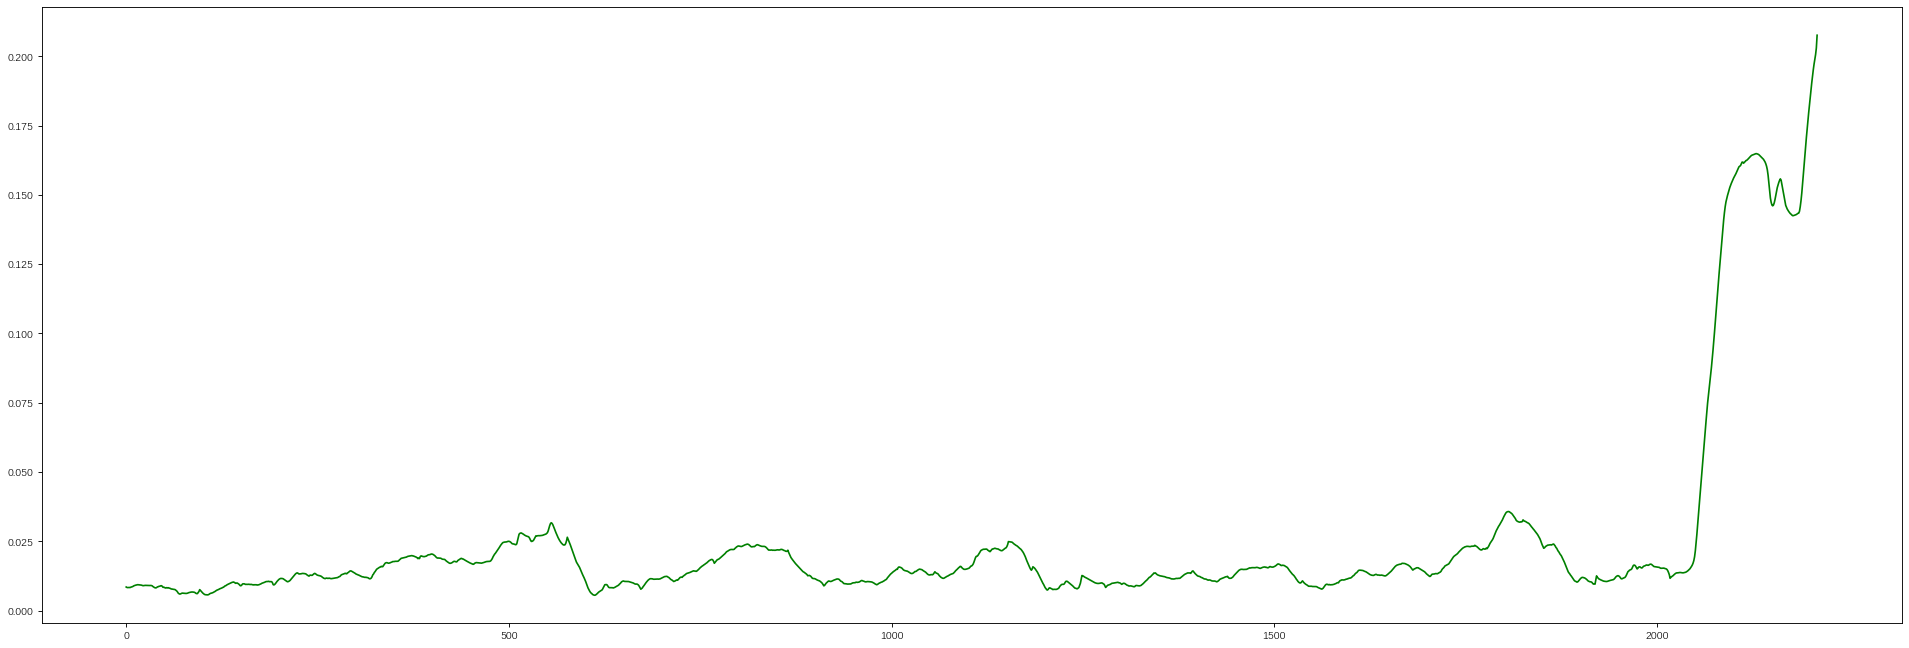

In [58]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(0, len(list1), len(list1), endpoint=True)
plt.plot(X, list1, color='green')
plt.show()

测试数据负荷值的折线图

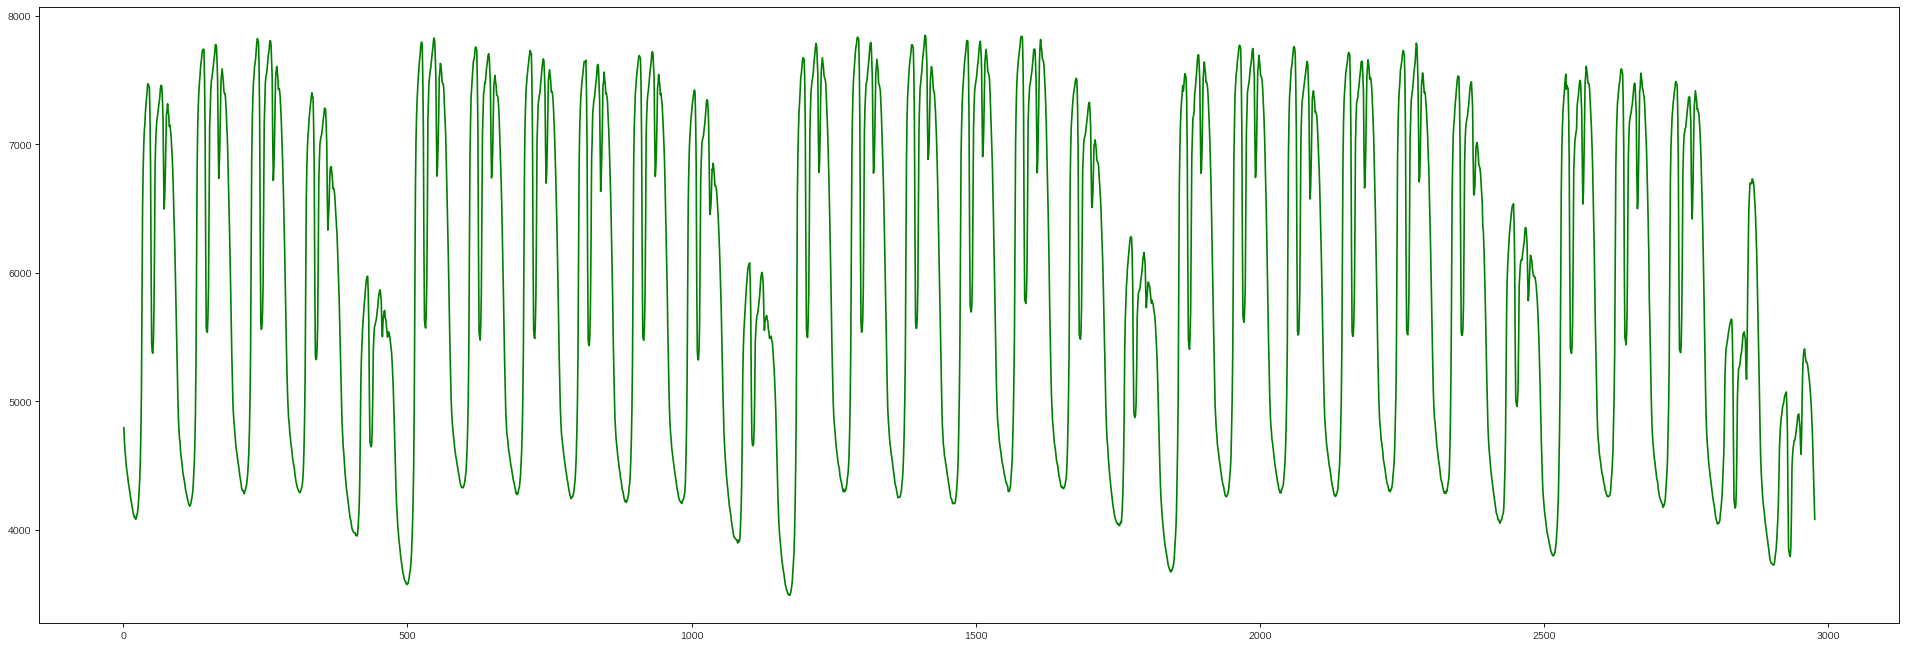

In [59]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, len(test), len(test), endpoint=True)
plt.plot(X, test['value'], color='green')
plt.show()

除去误差较大的预测结果后

In [60]:
list2 = list1[:2000]

In [61]:
str(sum(list2) / len(list2) * 100) + '%'

'1.4876580110285431%'

<Axes: >

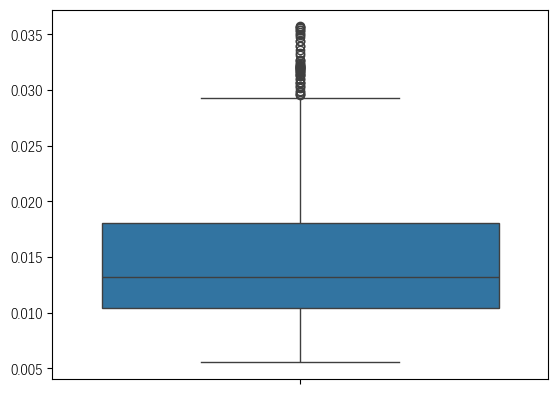

In [62]:
sns.boxplot(data=list2)

(0.0, 0.05)

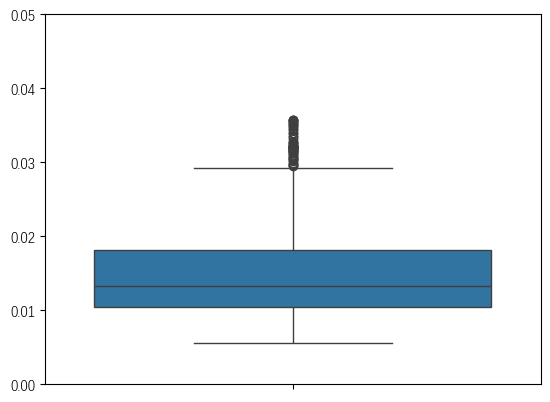

In [63]:
sns.boxplot(data=list2)
plt.ylim(0, 0.05)

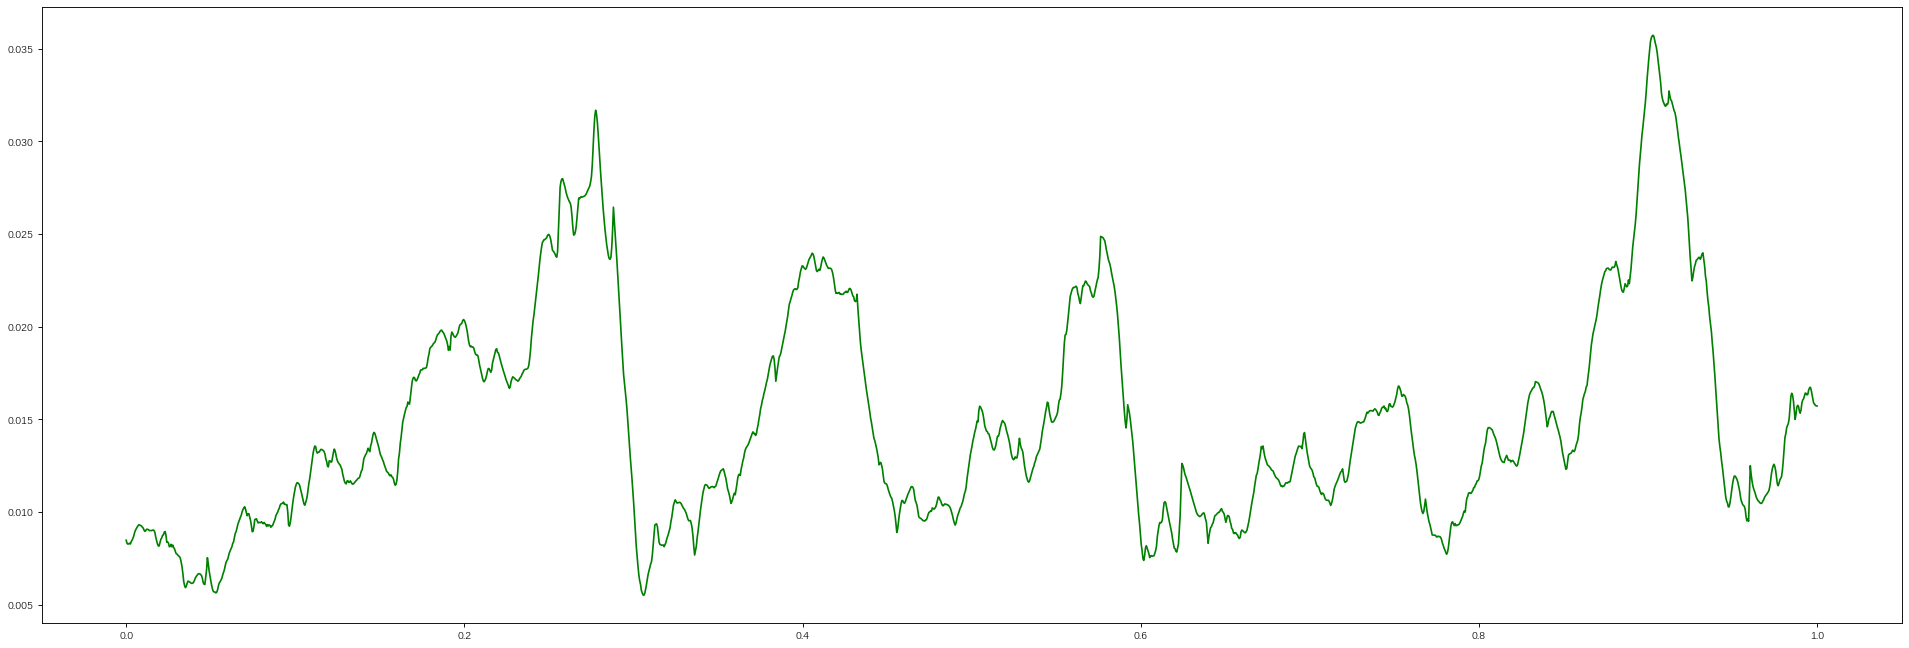

In [64]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(0, 1, len(list2), endpoint=True)
plt.plot(X, list2, color='green')
plt.show()

训练过程中在训练集上损失的折线图（以小批量为单位）

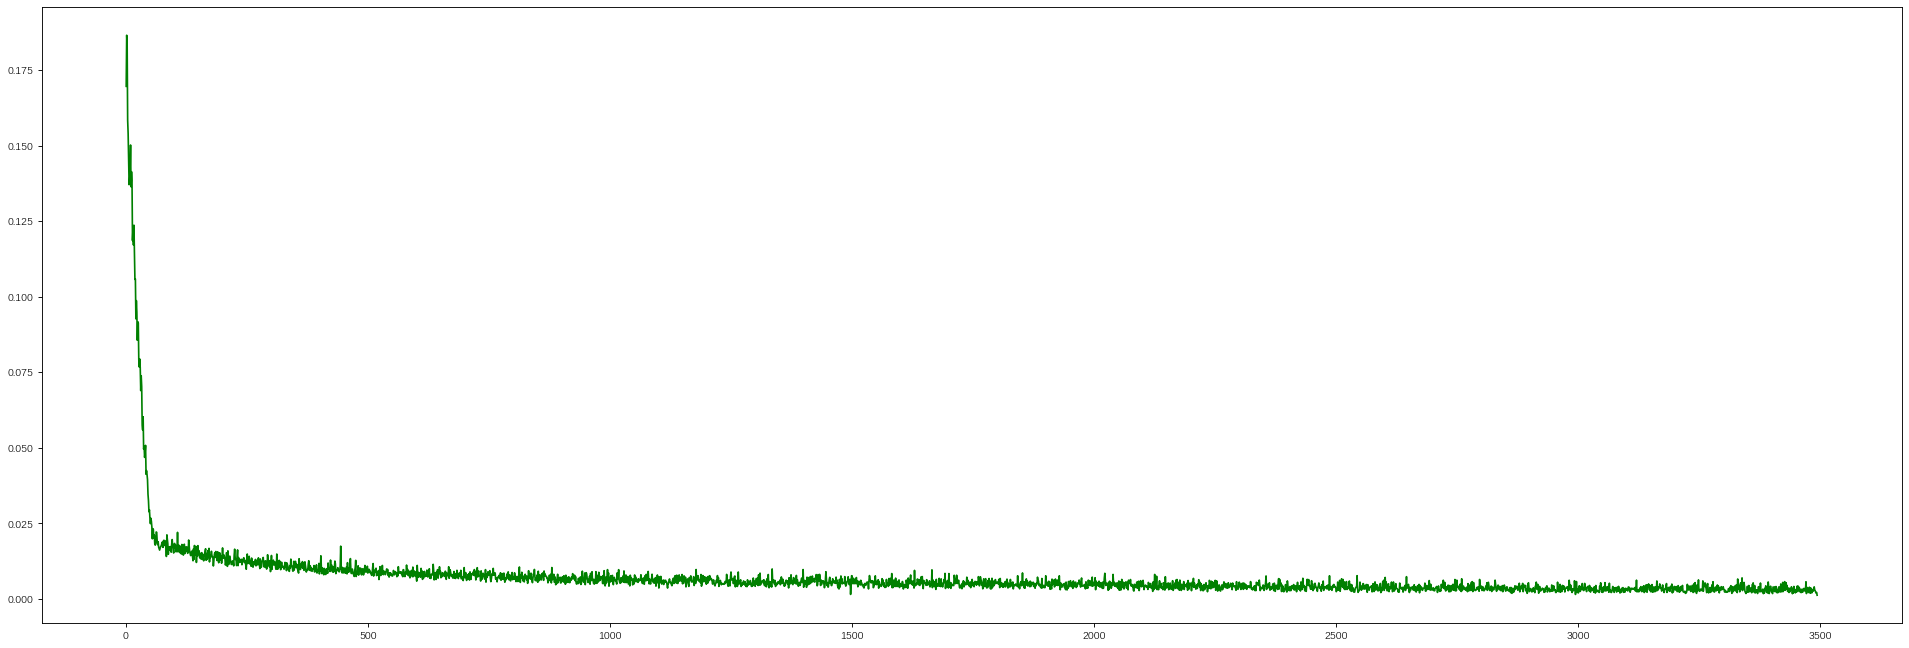

In [65]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, len(loss_list), len(loss_list), endpoint=True)
plt.plot(X, loss_list, color='green')
plt.show()

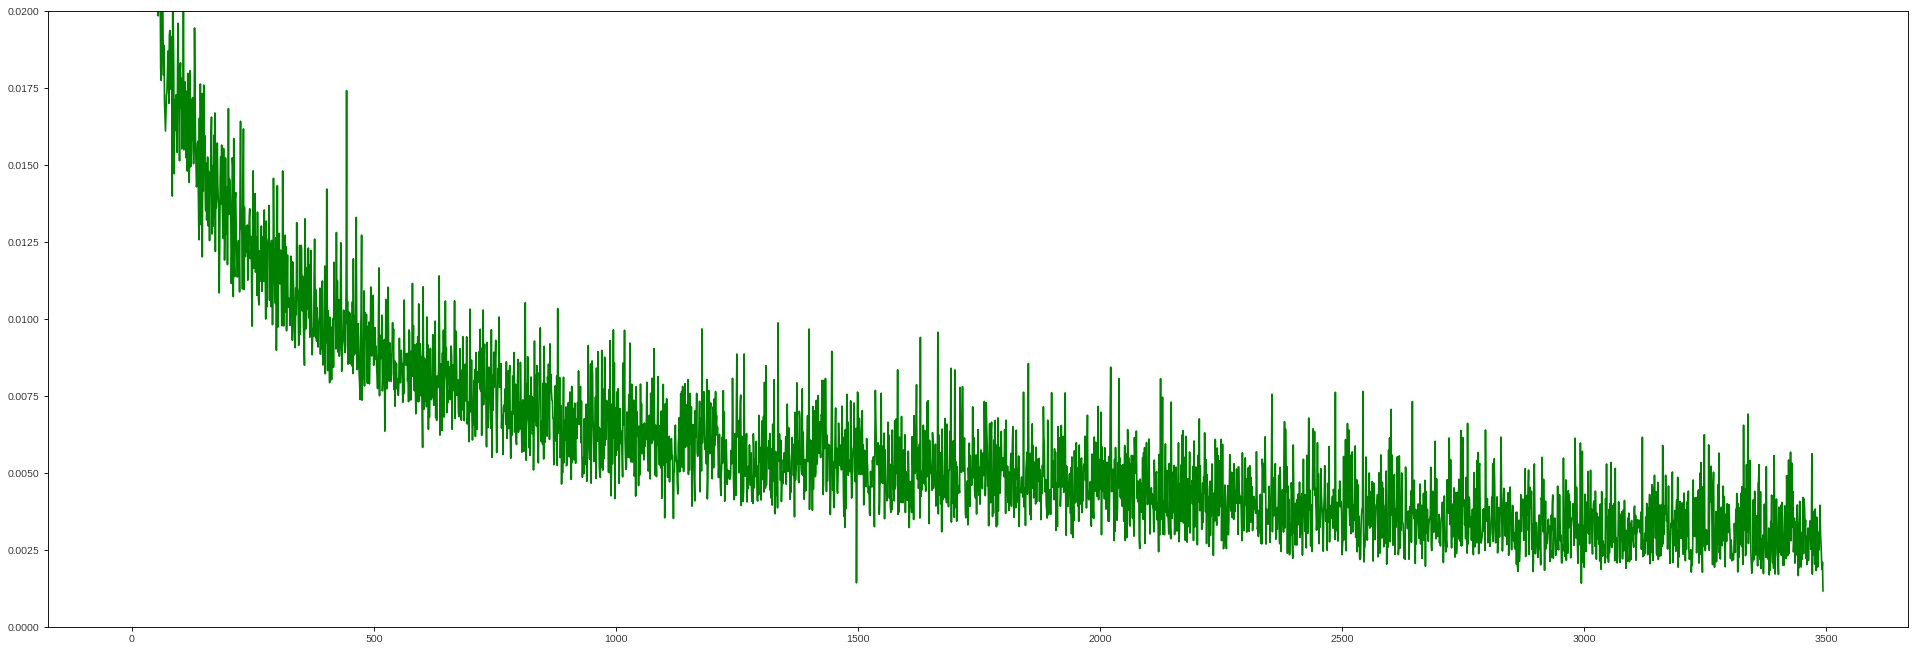

In [66]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, len(loss_list), len(loss_list), endpoint=True)
plt.plot(X, loss_list, color='green')
plt.ylim(0,0.02)
plt.show()

In [67]:
# 保存损失列表
np.save('./2-19-loss_list.npy', loss_list)
# 加载损失列表
a = np.load('2-19-loss_list.npy')

In [68]:
# 考虑将要预测的第一个时刻的特征和预测时刻前24小时的那个时刻的负荷组成一个序列，预测的第二个时刻的特征和预测时刻前24小时的那个时刻的负荷组成
# 一个序列......，最终一个样本有96个序列，分别对应要预测的96个时刻。就像实训2-9那样。
# 考虑新增一个特征：是否为休息日（或工作日），并将节假日的调休去掉。

In [69]:
df1 = pd.DataFrame(np.load('tree_mape.npy'), columns=['决策树'])
df2 = pd.DataFrame(np.load('fcnn_mape.npy'), columns=['全连接神经网络'])
df3 = pd.DataFrame(np.load('lstm11_mape.npy'), columns=['LSTM-11'])
df4 = pd.DataFrame(np.load('lstm19_mape.npy'), columns=['LSTM-19'])
df = pd.concat([df1, df2, df3, df4], axis=1)

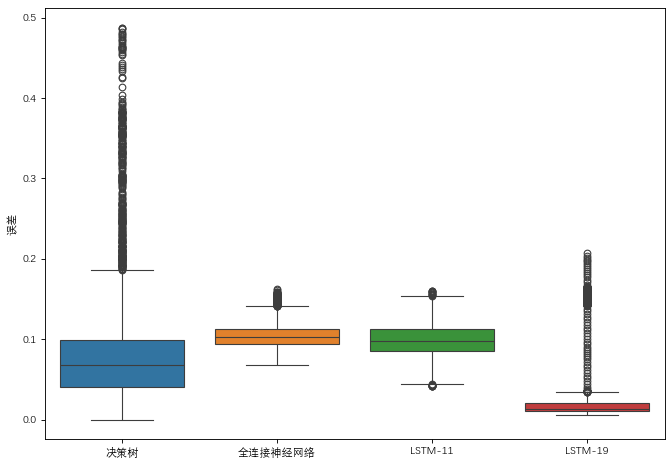

In [70]:
plt.figure(figsize=(10,7), dpi= 80)
sns.boxplot(data=df)
plt.ylabel('误差')
plt.show()

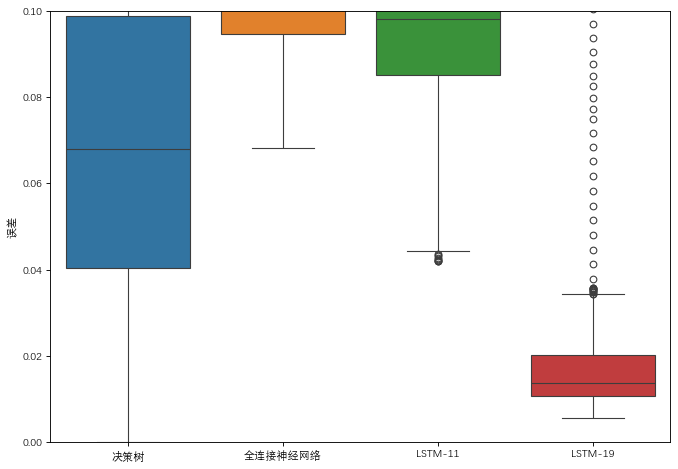

In [71]:
plt.figure(figsize=(10,7), dpi= 80)
sns.boxplot(data=df)
plt.ylim(0,0.1)
plt.ylabel('误差')
plt.show()